### Import dependencies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
#from ps_lib import *
from skimage.transform import resize

### Load provided Gaussian kernel.

In [2]:
gaussian_kernel = np.load('gaussian-kernel.npy')

### Define helper functions and cross-correlation/convolution function.

In [7]:
gaussian_kernel

array([[0.00390625, 0.015625  , 0.0234375 , 0.015625  , 0.00390625],
       [0.015625  , 0.0625    , 0.09375   , 0.0625    , 0.015625  ],
       [0.0234375 , 0.09375   , 0.140625  , 0.09375   , 0.0234375 ],
       [0.015625  , 0.0625    , 0.09375   , 0.0625    , 0.015625  ],
       [0.00390625, 0.015625  , 0.0234375 , 0.015625  , 0.00390625]],
      dtype=float32)

In [87]:
def convolution(img, kernel):
    #conv with gaussian same size
    gaussian_convolved_img = cv2.GaussianBlur(img, (kernel.shape[0], kernel.shape[1]), 0)

    return gaussian_convolved_img

In [86]:
def make_one_D_kernel(kernel):
    MAX_ROWS = img.shape[0]
    MAX_COLS = img.shape[1]
    one_d_gaussian_kernel = kernel
    
    kernel_matrix = np.zeros((MAX_ROWS, MAX_ROWS))
    # print(kernel_matrix.shape)
    for m in range(MAX_ROWS):
    #     print(m)
    #     print(m+(len(one_d_gaussian_kernel)))
    #     print(one_d_gaussian_kernel)
    #     print()
        over = int(len(one_d_gaussian_kernel)/2)
        mid = over
        lower = max(0,m-over)
        upper = min(m+over, MAX_ROWS)
        kernel_lower = mid-over if m-over >= 0 else abs(m-over)
        kernel_upper = mid+over if m+over < MAX_ROWS else (mid+over)-(m+over-MAX_ROWS)
        kernel_matrix[m, lower:upper] = one_d_gaussian_kernel[kernel_lower:kernel_upper]
    return kernel_matrix
    
    

In [85]:
def down_sample(img, factor=2):
    #use nearest nerighbours to downsample
    small_img = resize(img, (int(img.shape[0]/factor), int(img.shape[1]/factor)), anti_aliasing=False)
    return small_img

In [84]:
def up_sample(img, factor=2):
    #upsample
    big_img = resize(img, (int(img.shape[0]*factor), int(img.shape[1]*factor)), anti_aliasing=False)
    return big_img

In [83]:
def one_level_laplacian(img,G):
    # generate Gaussian pyramid for Apple
    A = img.copy()

    # Gaussian blur on Apple
    A = convolution(A, G)

    # Downsample blurred A
    small_A = down_sample(A)
    
    # Upsample small, blurred A
    upsampled_A = up_sample(small_A)

    # generate Laplacian level for A
    laplace_A = A - upsampled_A
    
    # reconstruct A
#     reconstruct_A = laplace_A + upsampled_A
    
    return small_A, upsampled_A, laplace_A


In [18]:
def F_transform(small_A, G):
    large_A = up_sample(small_A)
    upsampled_A = convolution(large_A, G)
    return upsampled_A

In [19]:
def gamma_decode(img):
    new_img = np.zeros((img.shape))
    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            new_img[r,c,0] = np.power(img[r,c,0], 1/1.2)
            new_img[r,c,1] = np.power(img[r,c,1], 1/1.2)
            new_img[r,c,2] = np.power(img[r,c,2], 1/1.2)
    return new_img

## Run Laplacian Pyramid on Apple

In [20]:
img = Image.open('apple.png')
img = gamma_decode(np.asarray(img)/255)

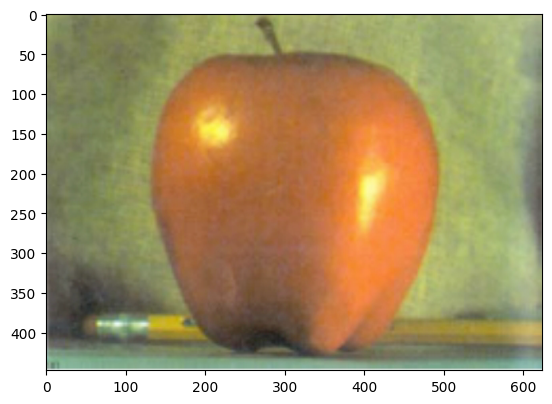

In [21]:
plt.imshow(img)
#plt.show()

In [22]:
img.shape

(448, 624, 3)

In [23]:
MAX_ROWS = img.shape[0]
MAX_COLS = img.shape[1]
print("MAX_ROWS = ", MAX_ROWS)
print("MAX_COLS = ", MAX_COLS)

MAX_ROWS =  448
MAX_COLS =  624


In [24]:
G = gaussian_kernel

In [28]:
import cv2

In [35]:
G = gaussian_kernel
apple_G_small_gaussian_blurred = []
apple_F_upsampled = []
apple_L_laplace = []

# Load Images
apple = Image.open('apple.png')
orange = Image.open('orange.png')
apple = gamma_decode(np.asarray(apple)/255.0)
orange = gamma_decode(np.asarray(orange)/255.0)

img = apple

for i in range(4):
    A, B, C = one_level_laplacian(img,G)
    apple_G_small_gaussian_blurred.append(A)
    apple_F_upsampled.append(B)
    apple_L_laplace.append(C)
    
    img = down_sample(img)
    

In [46]:
# reconstruct image
apple_reconstructed_imgs = []
start_F = apple_G_small_gaussian_blurred[-1]

for i in reversed(range(0, 4)):
#     print(start_F.shape)
#     print(L_laplace[i].shape)
    reconstructed_F = F_transform(start_F, G) + apple_L_laplace[i]
#     print(reconstructed_F.shape)
    apple_reconstructed_imgs.append(reconstructed_F)
    start_F = reconstructed_F
    

## Run Laplacian Pyramid on Orange

In [72]:

G = gaussian_kernel
orange_G_small_gaussian_blurred = []
orange_F_upsampled = []
orange_L_laplace = []

# # Load Images
apple = cv2.imread('apple.png')
orange = cv2.imread('orange.png')
apple = gamma_decode(apple)
orange = gamma_decode(orange)

img = orange.copy()

for i in range(4):
      A, B, C = one_level_laplacian(img,G)
      orange_G_small_gaussian_blurred.append(A)
      orange_F_upsampled.append(B)
      orange_L_laplace.append(C)
      
      img = down_sample(img)


In [73]:
# reconstruct image
orange_reconstructed_imgs = []
start_F = orange_G_small_gaussian_blurred[-1]

for i in reversed(range(0, 4)):
#     print()
#     print(start_F.shape)
#     print(orange_L_laplace[i].shape)
    reconstructed_F = F_transform(start_F, G) + orange_L_laplace[i]
#     print(reconstructed_F.shape)
    orange_reconstructed_imgs.append(reconstructed_F)
    start_F = reconstructed_F
    

## Run Gaussian Pyramid on Mask.png

In [74]:
mask = Image.open('mask.png')

In [75]:
new_mask = np.zeros((orange.shape[0], orange.shape[1]))

In [76]:
ncols = orange.shape[1]

In [77]:
new_mask[:, :int(ncols/2)]=255

In [78]:
mask = new_mask

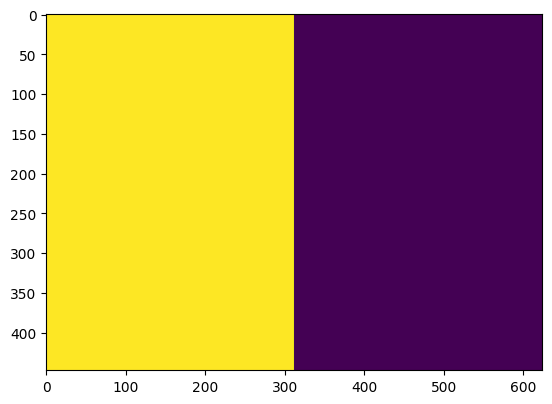

In [79]:
plt.imshow(mask)
plt.show()

In [80]:
mask.shape

(448, 624)

In [94]:
def one_layer_convolution(img, kernel):
    gaussian_convolved_img = cv2.GaussianBlur(img, (kernel.shape[0], kernel.shape[1]), 0)
    return gaussian_convolved_img



In [95]:
def one_layer_down_sample(img, factor=2):
    small_img = resize(img, (int(img.shape[0]/factor), int(img.shape[1]/factor)), anti_aliasing=False)
    return small_img

In [96]:
def one_level_gaussian_pyramid(img, G):
    # generate Gaussian pyramid for img
    A = img.copy()

    # Gaussian blur on img
    blurred_A = one_layer_convolution(A, G)

    # Downsample blurred A
    small_A = one_layer_down_sample(blurred_A)

    return small_A


In [100]:

G = gaussian_kernel
mask_G_small_gaussian_blurred = [mask]
F_upsampled = []
L_laplace = []

# Load Images


img = mask.copy()

for i in range(5):
    small_A = one_level_gaussian_pyramid(img, G)
    upsampled_A = up_sample(small_A)
    mask_G_small_gaussian_blurred.append(small_A)
    # F_upsampled.append(upsampled_A)
#     L_laplace.append(laplace_A)
    img = small_A
    

In [101]:
for i in range(len(mask_G_small_gaussian_blurred)):
    mask_G_small_gaussian_blurred[i] = mask_G_small_gaussian_blurred[i]/np.max(mask_G_small_gaussian_blurred[i])
    
    

In [102]:
np.max(mask_G_small_gaussian_blurred[-1])

1.0

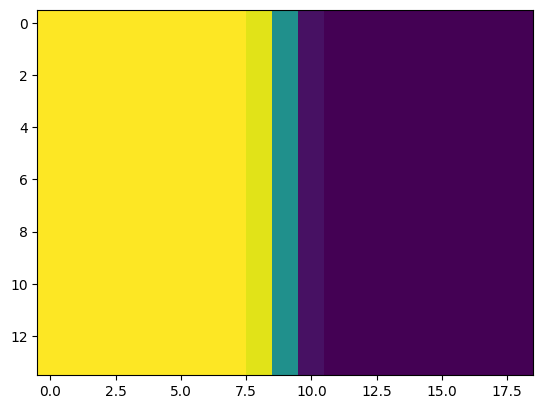

In [103]:
plt.imshow(mask_G_small_gaussian_blurred[-1])

## Time for Laplacian blending!

In [57]:
# orange_G_small_gaussian_blurred = []
# orange_F_upsampled = []
# orange_L_laplace = []

In [104]:
for i in mask_G_small_gaussian_blurred:
    print(i.shape)

(448, 624)
(224, 312)
(112, 156)
(56, 78)
(28, 39)
(14, 19)


In [105]:
for i in orange_G_small_gaussian_blurred:
    print(i.shape)

(224, 312, 3)
(112, 156, 3)
(56, 78, 3)
(28, 39, 3)


In [106]:
for i in orange_L_laplace:
    print(i.shape)

(448, 624, 3)
(224, 312, 3)
(112, 156, 3)
(56, 78, 3)


In [107]:
mask_apple_1d = mask_G_small_gaussian_blurred[-2]
mask_orange_1d = 1- mask_G_small_gaussian_blurred[-2]

mask_apple = np.stack(np.array([mask_apple_1d,mask_apple_1d,mask_apple_1d]), axis=2)
mask_orange = np.stack(np.array([mask_orange_1d,mask_orange_1d,mask_orange_1d]), axis=2)

G_c = apple_G_small_gaussian_blurred[-1]*mask_apple + \
        orange_G_small_gaussian_blurred[-1]*mask_orange

In [108]:
F_1 = up_sample(G_c)
upsampled_F1 = convolution(F_1, G)

In [109]:
mask_apple_1d = mask_G_small_gaussian_blurred[-3]
mask_orange_1d = 1- mask_G_small_gaussian_blurred[-3]

mask_apple = np.stack(np.array([mask_apple_1d,mask_apple_1d,mask_apple_1d]), axis=2)
mask_orange = np.stack(np.array([mask_orange_1d,mask_orange_1d,mask_orange_1d]), axis=2)

In [110]:
L_a = apple_L_laplace[-1]
L_o = orange_L_laplace[-1]

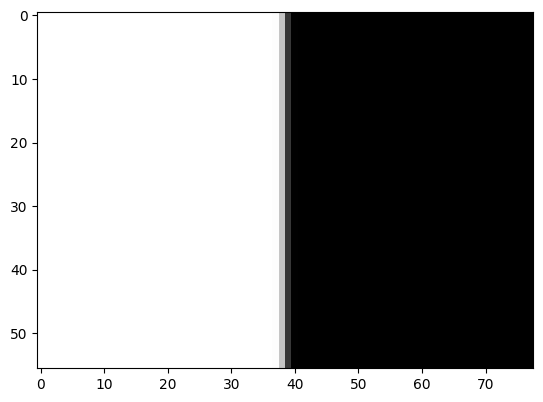

In [111]:
plt.imshow(mask_apple)

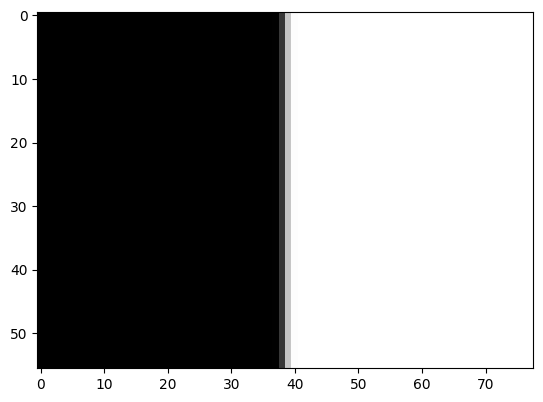

In [113]:
plt.imshow(mask_orange)

In [114]:
L_c = (mask_apple * L_a) + (mask_orange * L_o)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


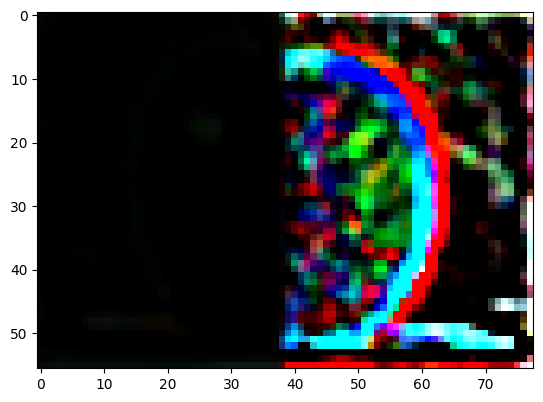

In [115]:
plt.imshow(L_c)

In [116]:
F_2 = L_c + upsampled_F1

In [117]:
upsampled_F1.shape

(56, 78, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


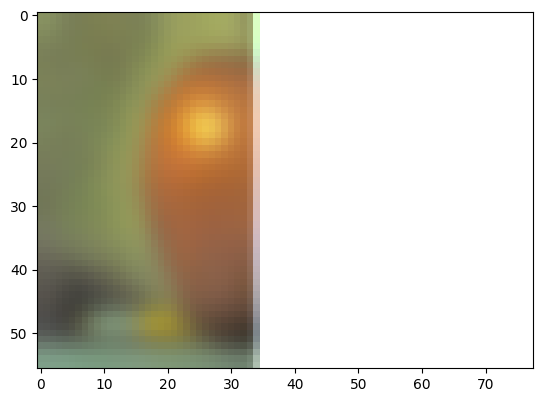

In [118]:
F1_plot = np.array(upsampled_F1)
plt.imshow(F1_plot)

In [119]:
new_L_c = L_c + (1-L_c)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


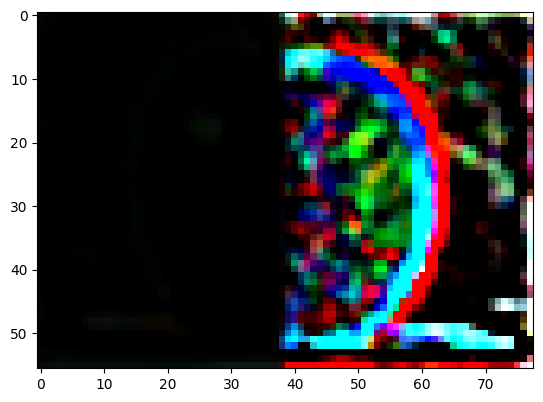

In [120]:
plt.imshow(L_c)

In [121]:
F_2 = L_c + upsampled_F1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


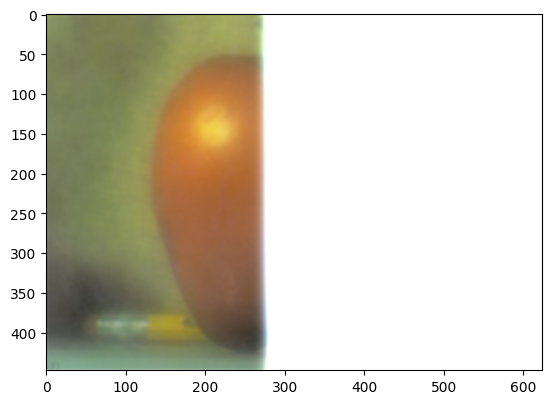

In [135]:
F2_plot = np.array(F_2)
plt.imshow(F2_plot)

In [123]:

reconstructed_imgs = []
mask_apple_1d = mask_G_small_gaussian_blurred[4]
mask_orange_1d = 1- mask_G_small_gaussian_blurred[4]

mask_apple = np.stack(np.array([mask_apple_1d,mask_apple_1d,mask_apple_1d]), axis=2)
mask_orange = np.stack(np.array([mask_orange_1d,mask_orange_1d,mask_orange_1d]), axis=2)

G_c = apple_G_small_gaussian_blurred[3]*mask_apple + \
        orange_G_small_gaussian_blurred[3]*mask_orange

F_1 = up_sample(G_c)
upsampled_F1 = convolution(F_1, G)

mask_apple_1d = mask_G_small_gaussian_blurred[3]
mask_orange_1d = 1- mask_G_small_gaussian_blurred[3]

mask_apple = np.stack(np.array([mask_apple_1d,mask_apple_1d,mask_apple_1d]), axis=2)
mask_orange = np.stack(np.array([mask_orange_1d,mask_orange_1d,mask_orange_1d]), axis=2)

L_a = apple_L_laplace[3]
L_o = orange_L_laplace[3]

L_c = (mask_apple * L_a) + (mask_orange * L_o)
F_2 = L_c + upsampled_F1
reconstructed_imgs.append(F_2)

In [124]:
# F_1 = F_2
F_1 = up_sample(F_2)
upsampled_F1 = convolution(F_1, G)

mask_apple_1d = mask_G_small_gaussian_blurred[2]
mask_orange_1d = 1- mask_G_small_gaussian_blurred[2]

mask_apple = np.stack(np.array([mask_apple_1d,mask_apple_1d,mask_apple_1d]), axis=2)
mask_orange = np.stack(np.array([mask_orange_1d,mask_orange_1d,mask_orange_1d]), axis=2)
print(mask_apple.shape)

L_a = apple_L_laplace[2]
L_o = orange_L_laplace[2]

L_c = (mask_apple * L_a) + (mask_orange * L_o)
print(upsampled_F1.shape)
F_2 = L_c + upsampled_F1
reconstructed_imgs.append(F_2)

(112, 156, 3)
(112, 156, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


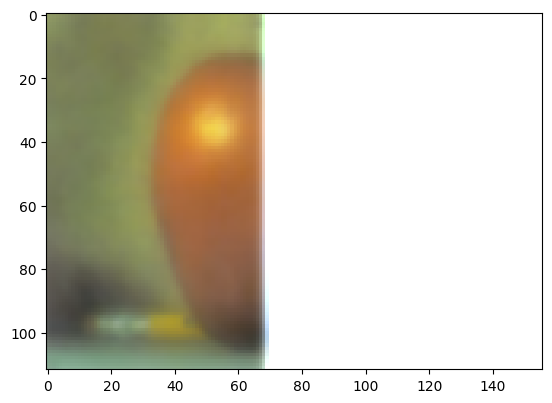

In [125]:
plt.imshow(F_2)

In [126]:
# F_1 = F_2
F_1 = up_sample(F_2)
upsampled_F1 = convolution(F_1, G)

mask_apple_1d = mask_G_small_gaussian_blurred[1]
mask_orange_1d = 1- mask_G_small_gaussian_blurred[1]

mask_apple = np.stack(np.array([mask_apple_1d,mask_apple_1d,mask_apple_1d]), axis=2)
mask_orange = np.stack(np.array([mask_orange_1d,mask_orange_1d,mask_orange_1d]), axis=2)
print(mask_apple.shape)

L_a = apple_L_laplace[1]
L_o = orange_L_laplace[1]

L_c = (mask_apple * L_a) + (mask_orange * L_o)
print(upsampled_F1.shape)
F_2 = L_c + upsampled_F1
reconstructed_imgs.append(F_2)

(224, 312, 3)
(224, 312, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


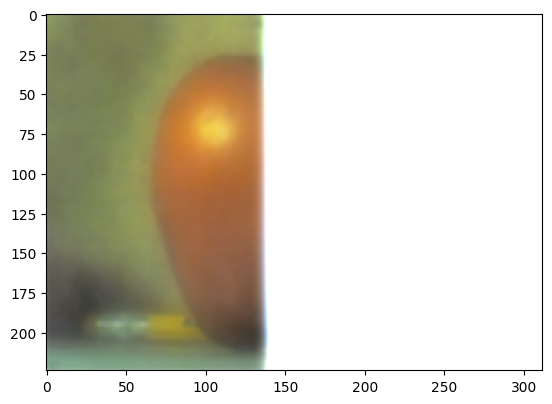

In [127]:
plt.imshow(F_2)

In [128]:
# F_1 = F_2
F_1 = up_sample(F_2)
upsampled_F1 = convolution(F_1, G)

mask_apple_1d = mask_G_small_gaussian_blurred[0]
mask_orange_1d = 1- mask_G_small_gaussian_blurred[0]

mask_apple = np.stack(np.array([mask_apple_1d,mask_apple_1d,mask_apple_1d]), axis=2)
mask_orange = np.stack(np.array([mask_orange_1d,mask_orange_1d,mask_orange_1d]), axis=2)
print(mask_apple.shape)

L_a = apple_L_laplace[0]
L_o = orange_L_laplace[0]

L_c = (mask_apple * L_a) + (mask_orange * L_o)
print(upsampled_F1.shape)
F_2 = L_c + upsampled_F1
reconstructed_imgs.append(F_2)

(448, 624, 3)
(448, 624, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


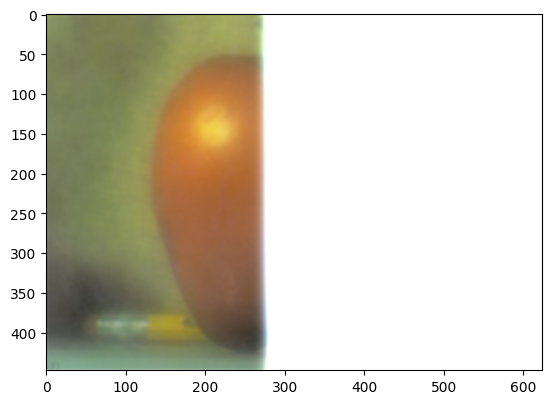

In [137]:
plt.imshow(F_2)

In [130]:
write_image(path='apple-and-orange.png', image=F_2)

NameError: name 'write_image' is not defined